# A1 Data Curation

The goal is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from July 1 2008 - September 30 2017

The section below is to establish shared variables and library among different stages

In [1]:
import pprint
import requests
import json

# Global variables
pagecounts_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/{apiname}/aggregate/en.wikipedia.org/{access}/monthly/{start}/{end}'
pageviews_url = 'https://wikimedia.org/api/rest_v1/metrics/{apiname}/aggregate/en.wikipedia.org/{access}/{agent}/monthly/{start}/{end}'
my_github = 'reyadji'
my_email = 'adjir@uw.edu'
default_params = {
    'apiname': 'pageviews',
    'access': 'mobile-web', 
    'agent': 'spider', 
    'start': '2008010100', 
    'end': '2016060100'}
json_files = []


def wikipedia_query(params=default_params):
    headers = {
        'User-Agent': 'https://github.com/{}'.format(my_github), 
        'From': my_email}
    url = ''
    if params['apiname'] is 'pageviews':
        url = pageviews_url
        params['start'] = '2015070100'
        params['end'] = '2017100100'
    elif params['apiname'] is 'pagecounts':
        url = pagecounts_url
        params['start'] = '2008010100'
        params['end'] = '2016080100'
    r = requests.get(url.format(**params), headers=headers)
#     print('URL: {}'.format(r.uri))
    print('Response status code: {}'.format(r.status_code))
#     print('Response JSON: {}'.format(pprint.pprint(r.json())))
    return r


def store_to_json(params, r):
    params['firstmonth'] = params['start'][:-2]
    params['lastmonth'] = params['end'][:-2]
    filename = '{apiname}_{access}_{firstmonth}-{lastmonth}.json'.format(**params)
    with open(filename, 'w+') as f:
        json.dump(r.json()['items'], f, indent=4)
    json_files.append(filename)

    
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

## Stage 1. Data Acquisition

Collect all months traffic data using two different Wikimedia REST API endpoints, Pagecounts and Pageviews, for both mobile and desktop (excluding spider bot).
Output is 5 JSON files:
1. pagecounts desktop
2. pagecounts mobile
3. pageview desktop
4. pageview mobile web
5. pageview mobile app

In [2]:
pc_desk_params = {
    'apiname': 'pagecounts',
    'access': 'desktop-site',
    'agent': ''}
r = wikipedia_query(pc_desk_params)
store_to_json(pc_desk_params, r)
print('Number of items: {}'.format(len(r.json()['items'])))

pc_mob_params = {
    'apiname': 'pagecounts',
    'access': 'mobile-site',
    'agent': ''}
r = wikipedia_query(pc_mob_params)
store_to_json(pc_mob_params, r)
print('Number of items: {}'.format(len(r.json()['items'])))

pv_desk_params = {
    'apiname': 'pageviews',
    'access': 'desktop',
    'agent': 'user'}
r = wikipedia_query(pv_desk_params)
store_to_json(pv_desk_params, r)
print('Number of items: {}'.format(len(r.json()['items'])))

pv_mobapp_params = {
    'apiname': 'pageviews',
    'access': 'mobile-app',
    'agent': 'user'}
r = wikipedia_query(pv_mobapp_params)
store_to_json(pv_mobapp_params, r)
print('Number of items: {}'.format(len(r.json()['items'])))

pv_mobweb_params = {
    'apiname': 'pageviews',
    'access': 'mobile-web',
    'agent': 'user'}
r = wikipedia_query(pv_mobweb_params)
store_to_json(pv_mobweb_params, r)
print('Number of items: {}'.format(len(r.json()['items'])))

print('JSON files: P{}'.format(json_files))



Response status code: 200
Number of items: 103
Response status code: 200
Number of items: 22
Response status code: 200
Number of items: 27
Response status code: 200
Number of items: 27
Response status code: 200
Number of items: 27
JSON files: P['pagecounts_desktop-site_20080101-20160801.json', 'pagecounts_mobile-site_20080101-20160801.json', 'pageviews_desktop_20150701-20171001.json', 'pageviews_mobile-app_20150701-20171001.json', 'pageviews_mobile-web_20150701-20171001.json']


The first step is to query each Wikipedia Rest API endpoint using $wikipedia_query$ function with different parameter combination. Each response then saved to a json file using $store_to_json$ function. Print statements are used to debug the number of items the response returns with. 
Two JSON files from two extra queries (all views for each API) are also produced to help with data processing in the next stage.

## Stage 2. Data Processing

Process these data files to prepare them for analysis by combining each JSON file into a single CSV file with these headers:
- year
- month
- pagecount_all_views
- pagecount_desktop_views
- pagecount_mobile_views
- pageview_all_views
- pageview_desktop_views
- pageview_mobile_views

In [3]:
import csv
import pandas as pd

csv_file = 'en-wikipedia_traffic_200801-201709.csv'

headers = [
    'timestamp',
    'year',
    'month',
    'pagecounts_all_views',
    'pagecounts_desktop_views',
    'pagecounts_mobile_views',
    'pageviews_all_views',
    'pageviews_desktop_views',
    'pageviews_mobile_views']

def load_df(file):
    apiname = file.split('_')[0]
    accesstype = file.split('_')[1].split('-')[0]
    column = apiname + '_' + accesstype + '_views'
    with open(file, 'r') as f:
        views = json.load(f)
    data = pd.DataFrame.from_dict(views)
    if apiname == 'pageviews':
        data = data.drop(['access','agent','granularity','project'], axis=1)
        data = data.rename(columns = {'views': column})
    #                 if 'mobile' in view['access']:
    else:
        data = data.drop(['access-site', 'granularity','project'], axis=1)
        data = data.rename(columns = {'count': column})
    return data


df = pd.DataFrame()
for i in json_files:
    # Load json file to pandas dataframe
    data = load_df(i)
    if len(df) == 0:
        df = data.copy(True)
    else:
        df = df.merge(data, on='timestamp', how='outer')

# Create year and month out of timestamp attribute
df = df.assign(year=df.timestamp.str[0:4])
df = df.assign(month=df.timestamp.str[4:6])
df.timestamp = df.timestamp.str[:-2]

# Combining two pageviews_mobile_views columns, one from mobile-app, and the other from mobile-web
df = df.assign(pageviews_mobile_views= lambda x: x.pageviews_mobile_views_x + x.pageviews_mobile_views_y)
df = df.drop(['pageviews_mobile_views_x', 'pageviews_mobile_views_y'], axis=1)

# Sum mobile and desktop to get all views
df = df.assign(pageviews_all_views= lambda x: x.pageviews_mobile_views + x.pageviews_desktop_views)
df = df.assign(pagecounts_all_views= lambda x: x.pagecounts_mobile_views + x.pagecounts_desktop_views)
df = df.fillna(value=0)

df.to_csv(csv_file, columns=headers, index = False)
        
        

There are two basicways to combine number of views from pageviews and pagecounts API: using Pandas library or using Python built-in library. I found out it is very difficult to pivot from the JSON files to year and month using Python built-in basic library. On the other hand, pandas provide a nice way to mung the data. Each JSON file is loaded to a pandas dataframe, all of which is merged on timestamp to a single dataframe. Year and month are derived from the timestamp, and pageviews' mobile app and mobile web numbers are combined. Mobile and desktop views are summed to get pagecounts' and apgeviews' all views. Finally, I replaced all non-existant value with 0 before saving the dataframe to a CSV file.   

## Stage 3. Analysis

Visualize the dataset as a time series graph. This will include mobile, desktop, and combined (mobile+desktop) traffic.

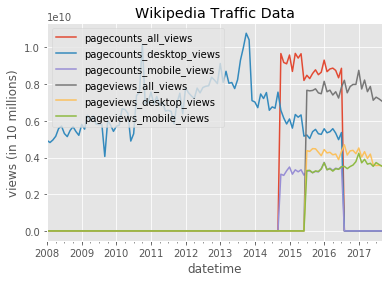

In [7]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
    
csv_file = 'en-wikipedia_traffic_200801-201709.csv'

# Read the CSV file to pandas dataframe in which the 'timestamp' column is the new index 
df = pd.read_csv(csv_file, index_col=0, parse_dates=[0], infer_datetime_format=True)
# Drop year and month columns since it's not needed for plotting
df = df.drop(['year','month'], axis=1)

plt.figure()
df.plot()

plt.xlabel('datetime')
plt.ylabel('views (in 10 millions)')
plt.title('Wikipedia Traffic Data')
plt.legend()
plt.savefig('en-wikipedia_traffic_200801-201709.png')
plt.show()

    
    


I use ggplot style since to plot Wikipedia traffic line chart since it's aesthetically more pleasing than the basic pyplot. The first step is to load the CSV file generated at previous stage to a pandas dataframe. After dropping unnecessary columns (year and month), it's pretty straight-forward to plot and label pagecounts_all_views, pagecounts_desktop_views, pagecounts_mobile_views, pageviews_all_views, pageviews_desktop_views, and pageviews_mobile_views numbers. Finally, the figure is saved to the a png file.